In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_15 import VitalSignsDataset,vital_pre_train
from model.tdpsom.tdospm import *
from model.tdpsom.tdospm_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


# labels_train = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][-1]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][-1]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

# ## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=32,sampler=train_sampler,collate_fn=vital_pre_train )
# val_loader = DataLoader( dataset_val,batch_size=32,sampler=val_sampler,collate_fn=vital_pre_train)
# test_loader = DataLoader( dataset_test,batch_size=32,sampler=test_sampler,collate_fn=vital_pre_train )


train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/tdpsom"

model = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-4)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer_pred = torch.optim.Adam(model.predictor.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=120, save_dir=stage1_dir, patience=50,kl_warmup_epochs=80)

[Epoch 0] KL weight: 0.0000, KL: 0.0000
[Epoch 1] KL weight: 0.0250, KL: 4.3050
[Epoch 2] KL weight: 0.0500, KL: 6.7724
[Epoch 3] KL weight: 0.0750, KL: 8.0476
[Epoch 4] KL weight: 0.1000, KL: 8.9701
[Epoch 5] KL weight: 0.1250, KL: 9.7286
[Epoch 6] KL weight: 0.1500, KL: 10.3048
[Epoch 7] KL weight: 0.1750, KL: 10.6008
[Epoch 8] KL weight: 0.2000, KL: 10.7480
[Epoch 9] KL weight: 0.2250, KL: 10.6616
[Epoch 10] KL weight: 0.2500, KL: 10.4250
[Epoch 11] KL weight: 0.2750, KL: 10.0216
[Epoch 12] KL weight: 0.3000, KL: 10.0268
[Epoch 13] KL weight: 0.3250, KL: 9.7868
[Epoch 14] KL weight: 0.3500, KL: 9.8162
[Epoch 15] KL weight: 0.3750, KL: 9.7756
[Epoch 16] KL weight: 0.4000, KL: 9.8212
[Epoch 17] KL weight: 0.4250, KL: 9.6609
[Epoch 18] KL weight: 0.4500, KL: 9.6465
[Epoch 19] KL weight: 0.4750, KL: 9.5793
[Epoch 20] KL weight: 0.5000, KL: 9.5508
[Epoch 21] KL weight: 0.5250, KL: 9.6479
[Epoch 22] KL weight: 0.5500, KL: 9.6076
[Epoch 23] KL weight: 0.5750, KL: 9.5391
[Epoch 24] KL weigh

In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v3/stage1/best_ae.pth'
# model1 = PatientAutoencoder(
#     n_features=154, embedding_dim=128,  n_heads=2, som_grid=(10,10)
# ).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

 Initialized SOM with 100 embeddings (4 classes with 25 samples)


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=100,save_dir=stage2_dir,patience=50)

[SOM] Phase 1 Epoch 10/100 Avg Loss: 0.0146
[SOM] Phase 1 Epoch 20/100 Avg Loss: 0.0121
[SOM] Phase 1 Epoch 30/100 Avg Loss: 0.0110
[SOM] Phase 2 Epoch 40/100 Avg Loss: 0.0114
[SOM] Phase 2 Epoch 50/100 Avg Loss: 0.0115
[SOM] Phase 2 Epoch 60/100 Avg Loss: 0.0114
[SOM] Phase 3 Epoch 70/100 Avg Loss: 0.0113
[SOM] Early stopping at epoch 76


In [ ]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/tdpsom/stage2/best_joint.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...


[Joint] Offset dict built for 2150 patients. Total length: 3126284
[Joint] Calculating fixed patient_start_offset_global (once before training)...


[Joint] Fixed patient_start_offset_global calculated. Shape: torch.Size([2150])


[Joint] Early stopping at epoch 63 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


In [ ]:
## 32
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]
selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

Extracting latent representations for 100 samples...
Using labels for coloring. Unique labels found: [0 1 2 3]
Performing dimensionality reduction on 100 latent vectors...
Dimensionality reduction complete.


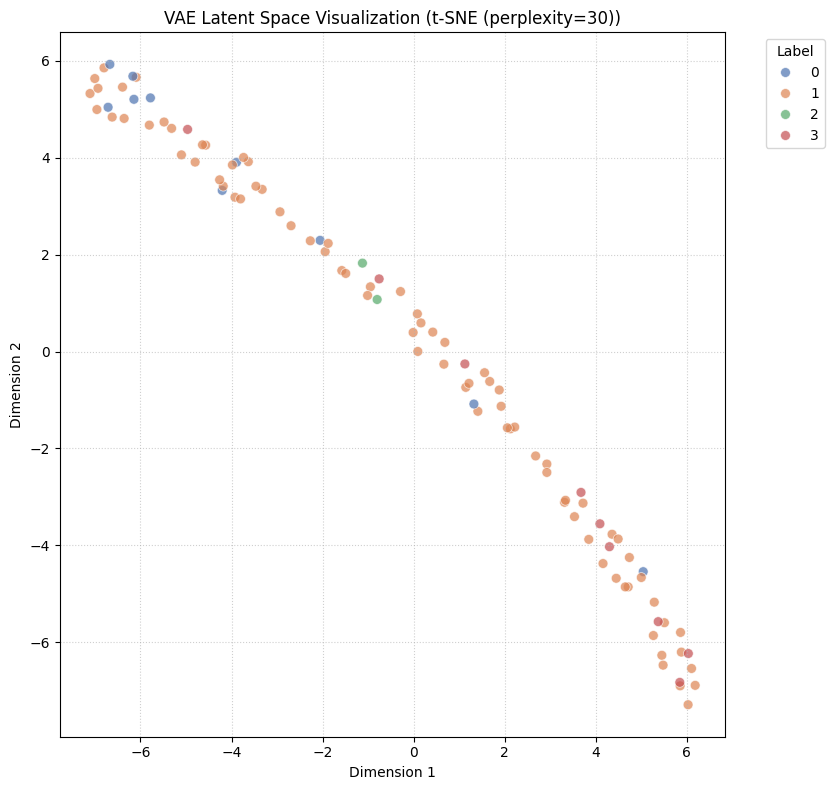

In [9]:
visualize_latent_space(model3, test_loader, device, num_samples_to_plot=100, use_tsne=True, labels_available=True, save_path=None)

Analyzing latent statistics for 20 batches...

--- Latent Space Statistics ---
Analyzed 468683 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean of mu (across all samples and dims): 0.1608
  Std of mu (across all samples and dims): 0.6125
  Mean of mu per latent dim (avg over samples):
tensor([ 0.6583,  0.6832,  0.6337, -0.6266,  0.4984, -0.4229, -0.6204,  0.5242,
        -0.2457,  0.6436,  0.7634,  0.5308, -0.3679,  0.6692,  0.2323,  0.8910,
         0.7610,  0.6002, -0.5508,  0.6720, -0.6114, -0.5262, -0.8008, -0.5849,
         0.6001, -0.5882,  0.3667, -0.4200,  0.6148,  0.5328,  0.2045,  0.8764,
         0.5634, -0.5302, -0.5887,  1.0497,  0.8468,  0.5260, -0.6934, -0.4186,
         0.2088,  0.2754, -0.4670,  0.5836,  0.7234,  0.6479, -0.7221, -0.6709,
        -0.5593, -0.5962,  0.4312,  0.7301,  0.7362,  0.6852, -0.6375,  0.6085,
         0.6661,  0.6344, -0.7162,  0.7574,  0.6315,  0.8078, -0.5588, -0.2524])
  Std of mu per latent dim (avg over samples):
tensor([0.0717, 0.0772

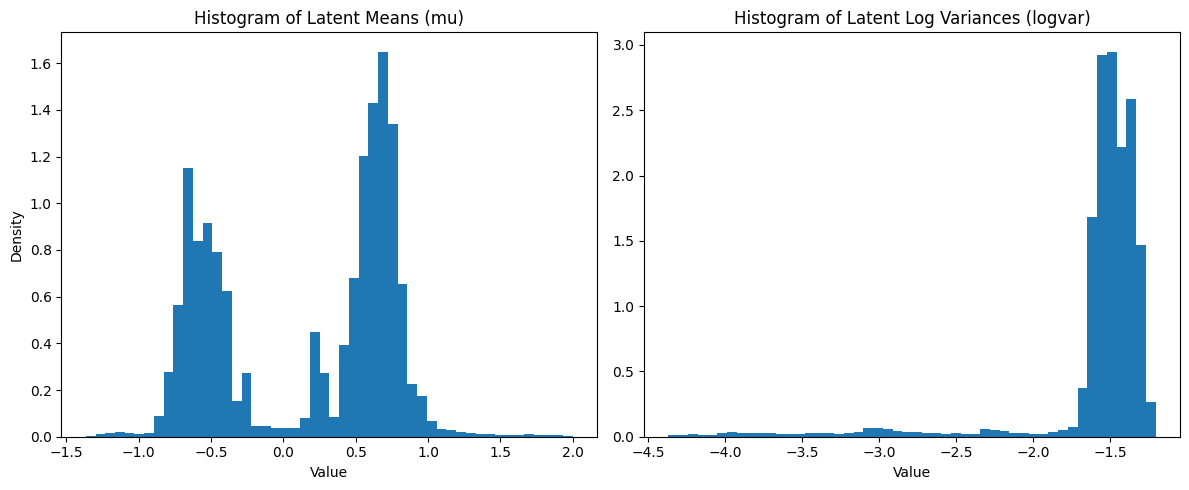

In [10]:
analyze_latent_stats(model3, test_loader, device, num_batches_to_analyze=20)

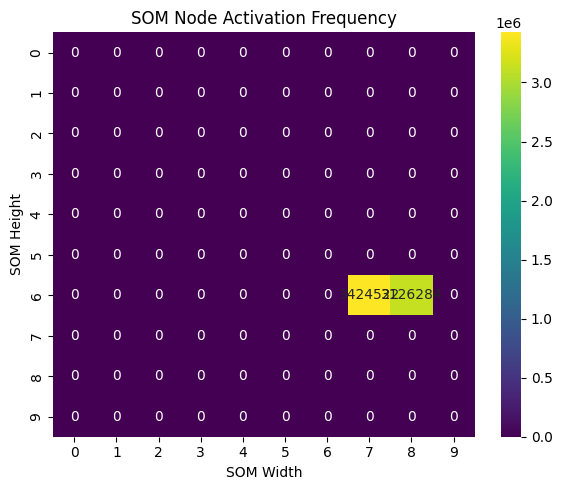

In [13]:
activation_map = compute_som_activation_heatmap(model2, train_loader, device)
plot_som_activation_heatmap(activation_map)